# Peak analysis

Analyze the peak location of ACh and DA

In [1]:
%reload_ext autoreload
%autoreload 2
import xarray as xr
import matplotlib.pylab as plt
import seaborn as sns
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
from glob import glob
import re
from datetime import datetime
from trialexp.process.folder_org.utils import build_session_info, load_and_concat_dataset, filter_sessions
from trialexp.process.group_analysis.plot_utils import *
from trialexp.process.pycontrol.plot_utils import trial_outcome_palette
import itertools
import patchworklib as pw
from scipy import signal

<Figure size 100x100 with 0 Axes>

## Load selected sessions

In [75]:
#specify the location of the by_sessions folder here
root_path = '/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions'
figure_out_path = '/home/MRC.OX.AC.UK/ndcn1330/ettin/Teris/DATA/ASAP_meeting_June2023'

DA_sessions = pd.read_pickle('DA_sessions.pkl')
ACh_sessions = pd.read_pickle('ACh_sessions.pkl')

## Read xarray datasets

In [3]:
#select the last 5 sessions from animal kms058
ds_combined_DA = load_and_concat_dataset(DA_sessions.path)
ds_combined_ACh = load_and_concat_dataset(ACh_sessions.path)

  0%|          | 0/31 [00:00<?, ?it/s]

/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms063-2023-04-01-180930/processed/xr_session.nc not found! skipping
/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms062-2023-02-23-143355/processed/xr_session.nc not found! skipping
/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/kms064-2023-02-14-115018/processed/xr_session.nc not found! skipping
Concating datasets...


  0%|          | 0/23 [00:00<?, ?it/s]

/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/TT001-2023-06-02-163605/processed/xr_session.nc not found! skipping
/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/TT005-2023-06-02-152309/processed/xr_session.nc not found! skipping
/home/MRC.OX.AC.UK/ndcn1330/ettin/Julien/Data/head-fixed/by_sessions/reaching_go_spout_bar_nov22/RE607-2023-06-05-131232/processed/xr_session.nc not found! skipping
Concating datasets...


In [4]:
animal_id_DA = DA_sessions[['animal_id','session_id', 'expt_datetime']]
animal_id_ACh = ACh_sessions[['animal_id','session_id', 'expt_datetime']]

## Analyze peaks

  0%|          | 0/4 [00:00<?, ?it/s]

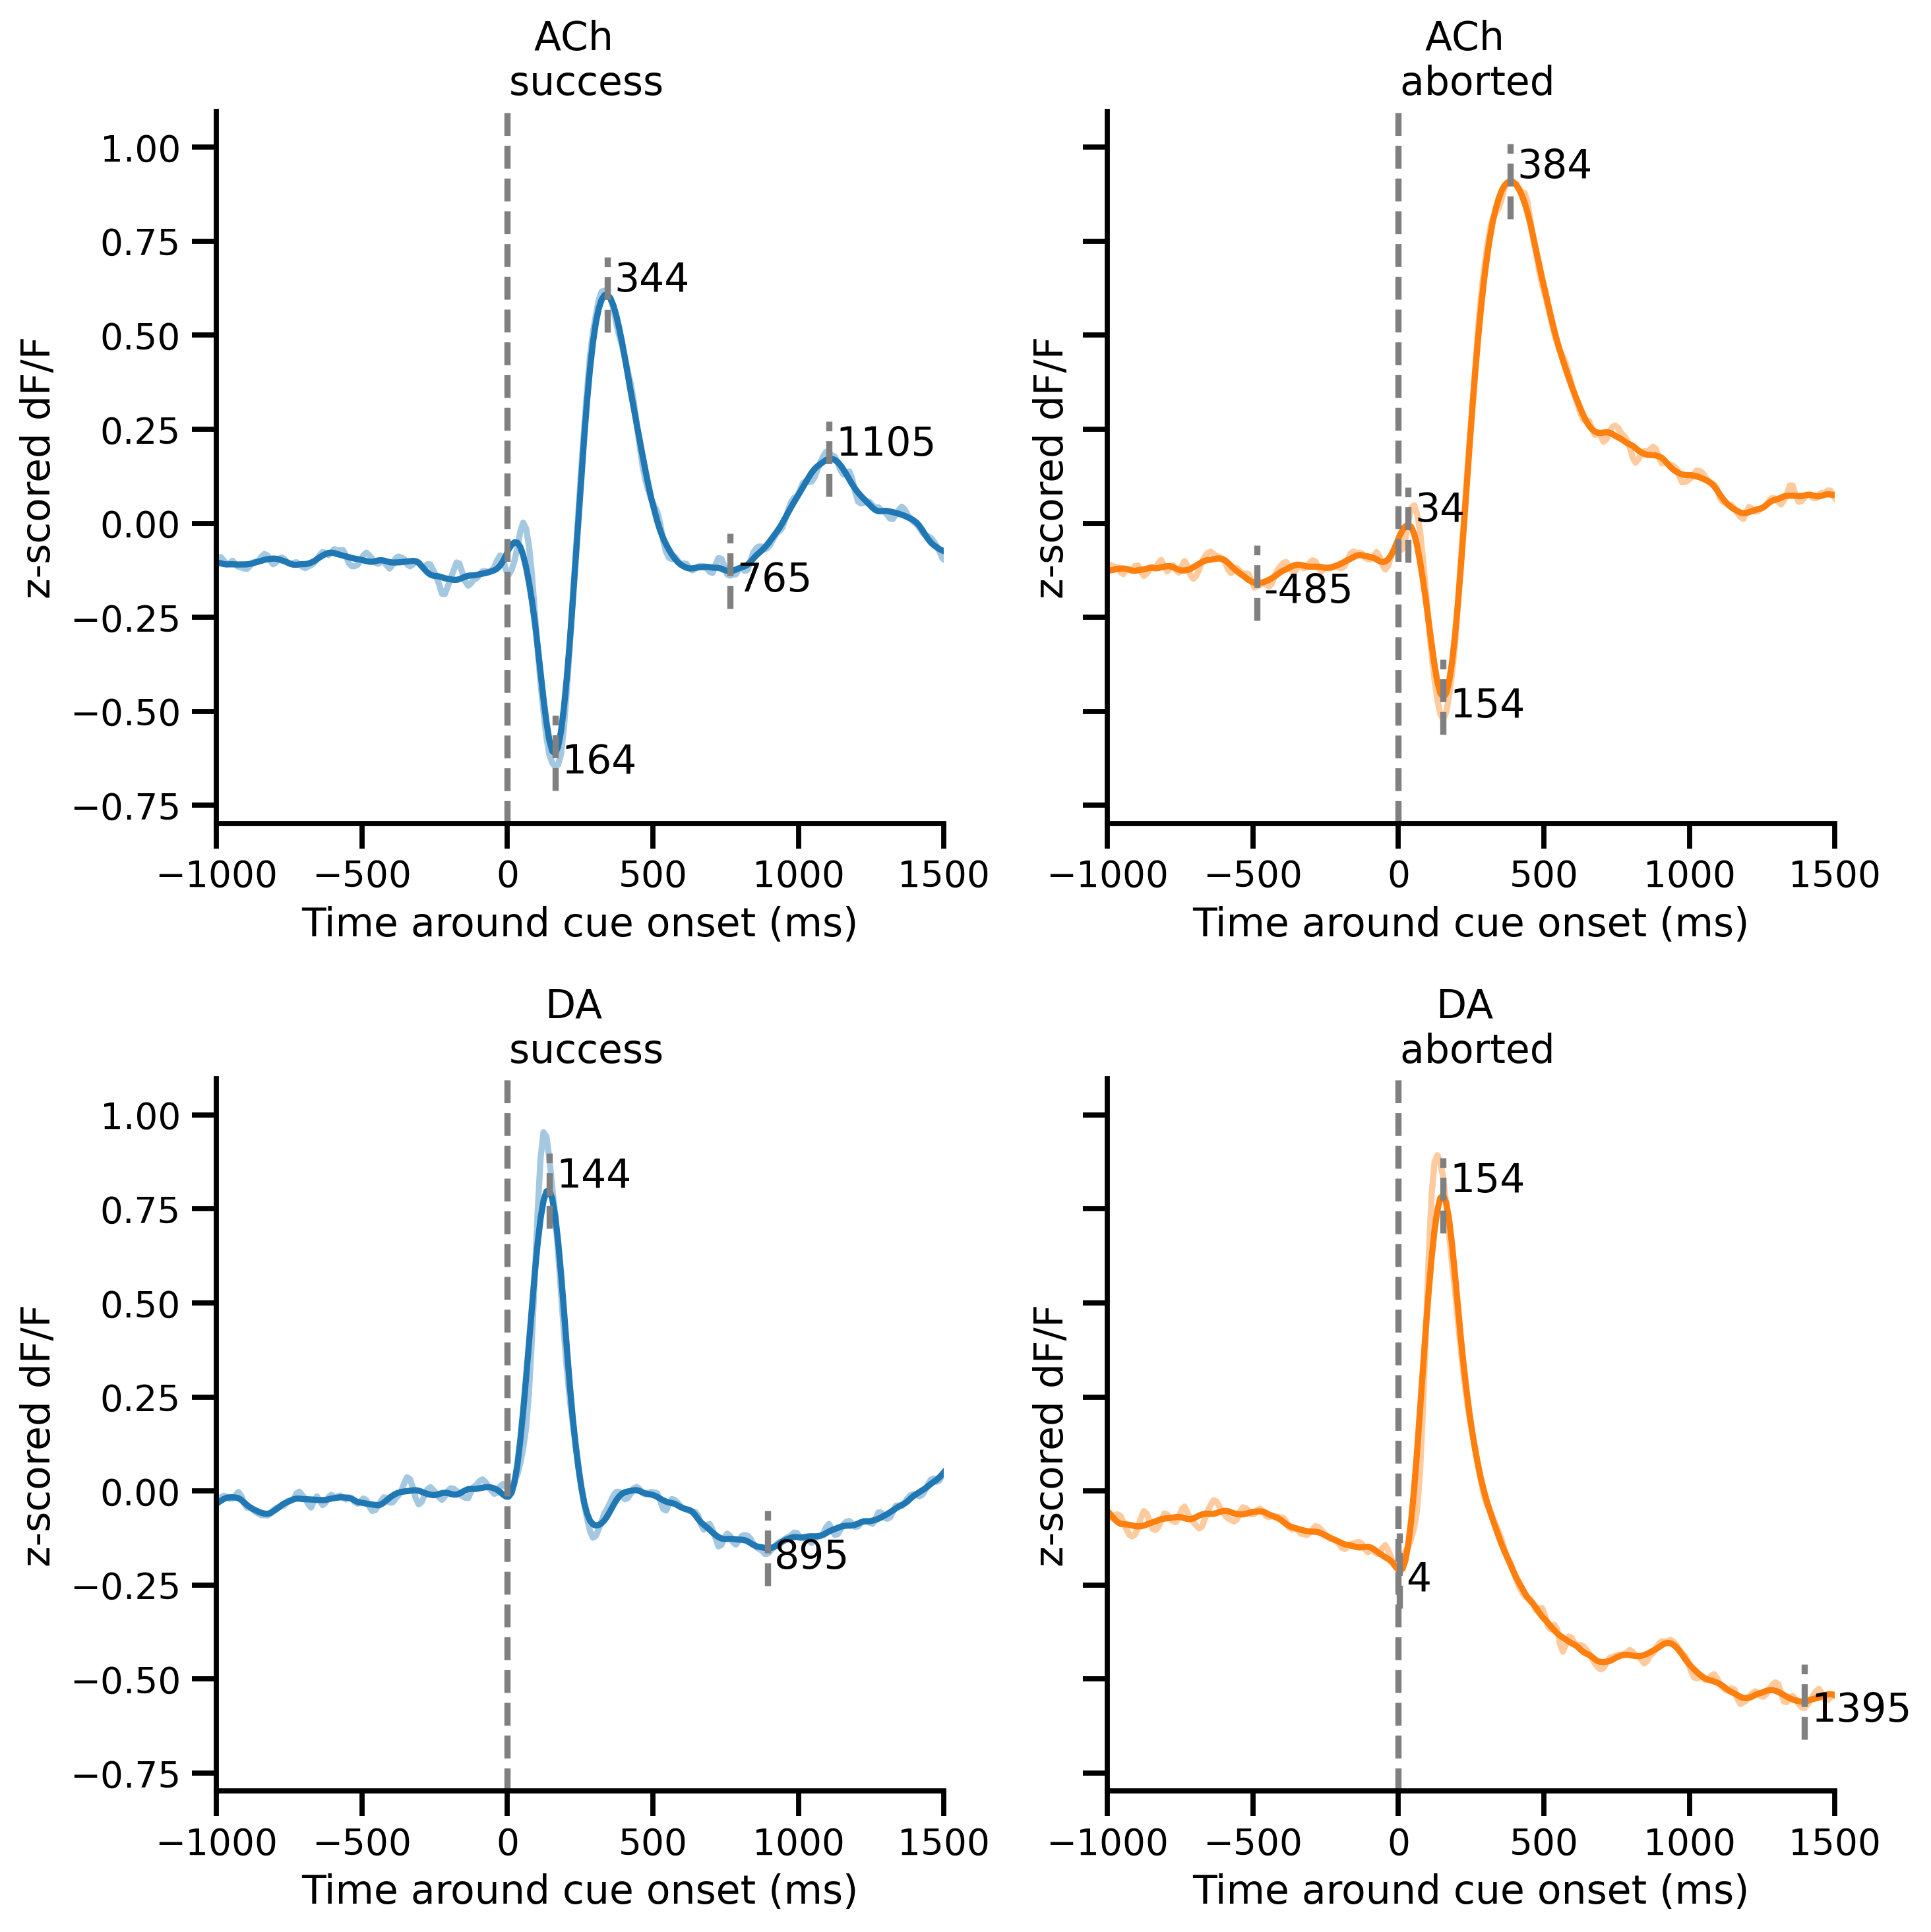

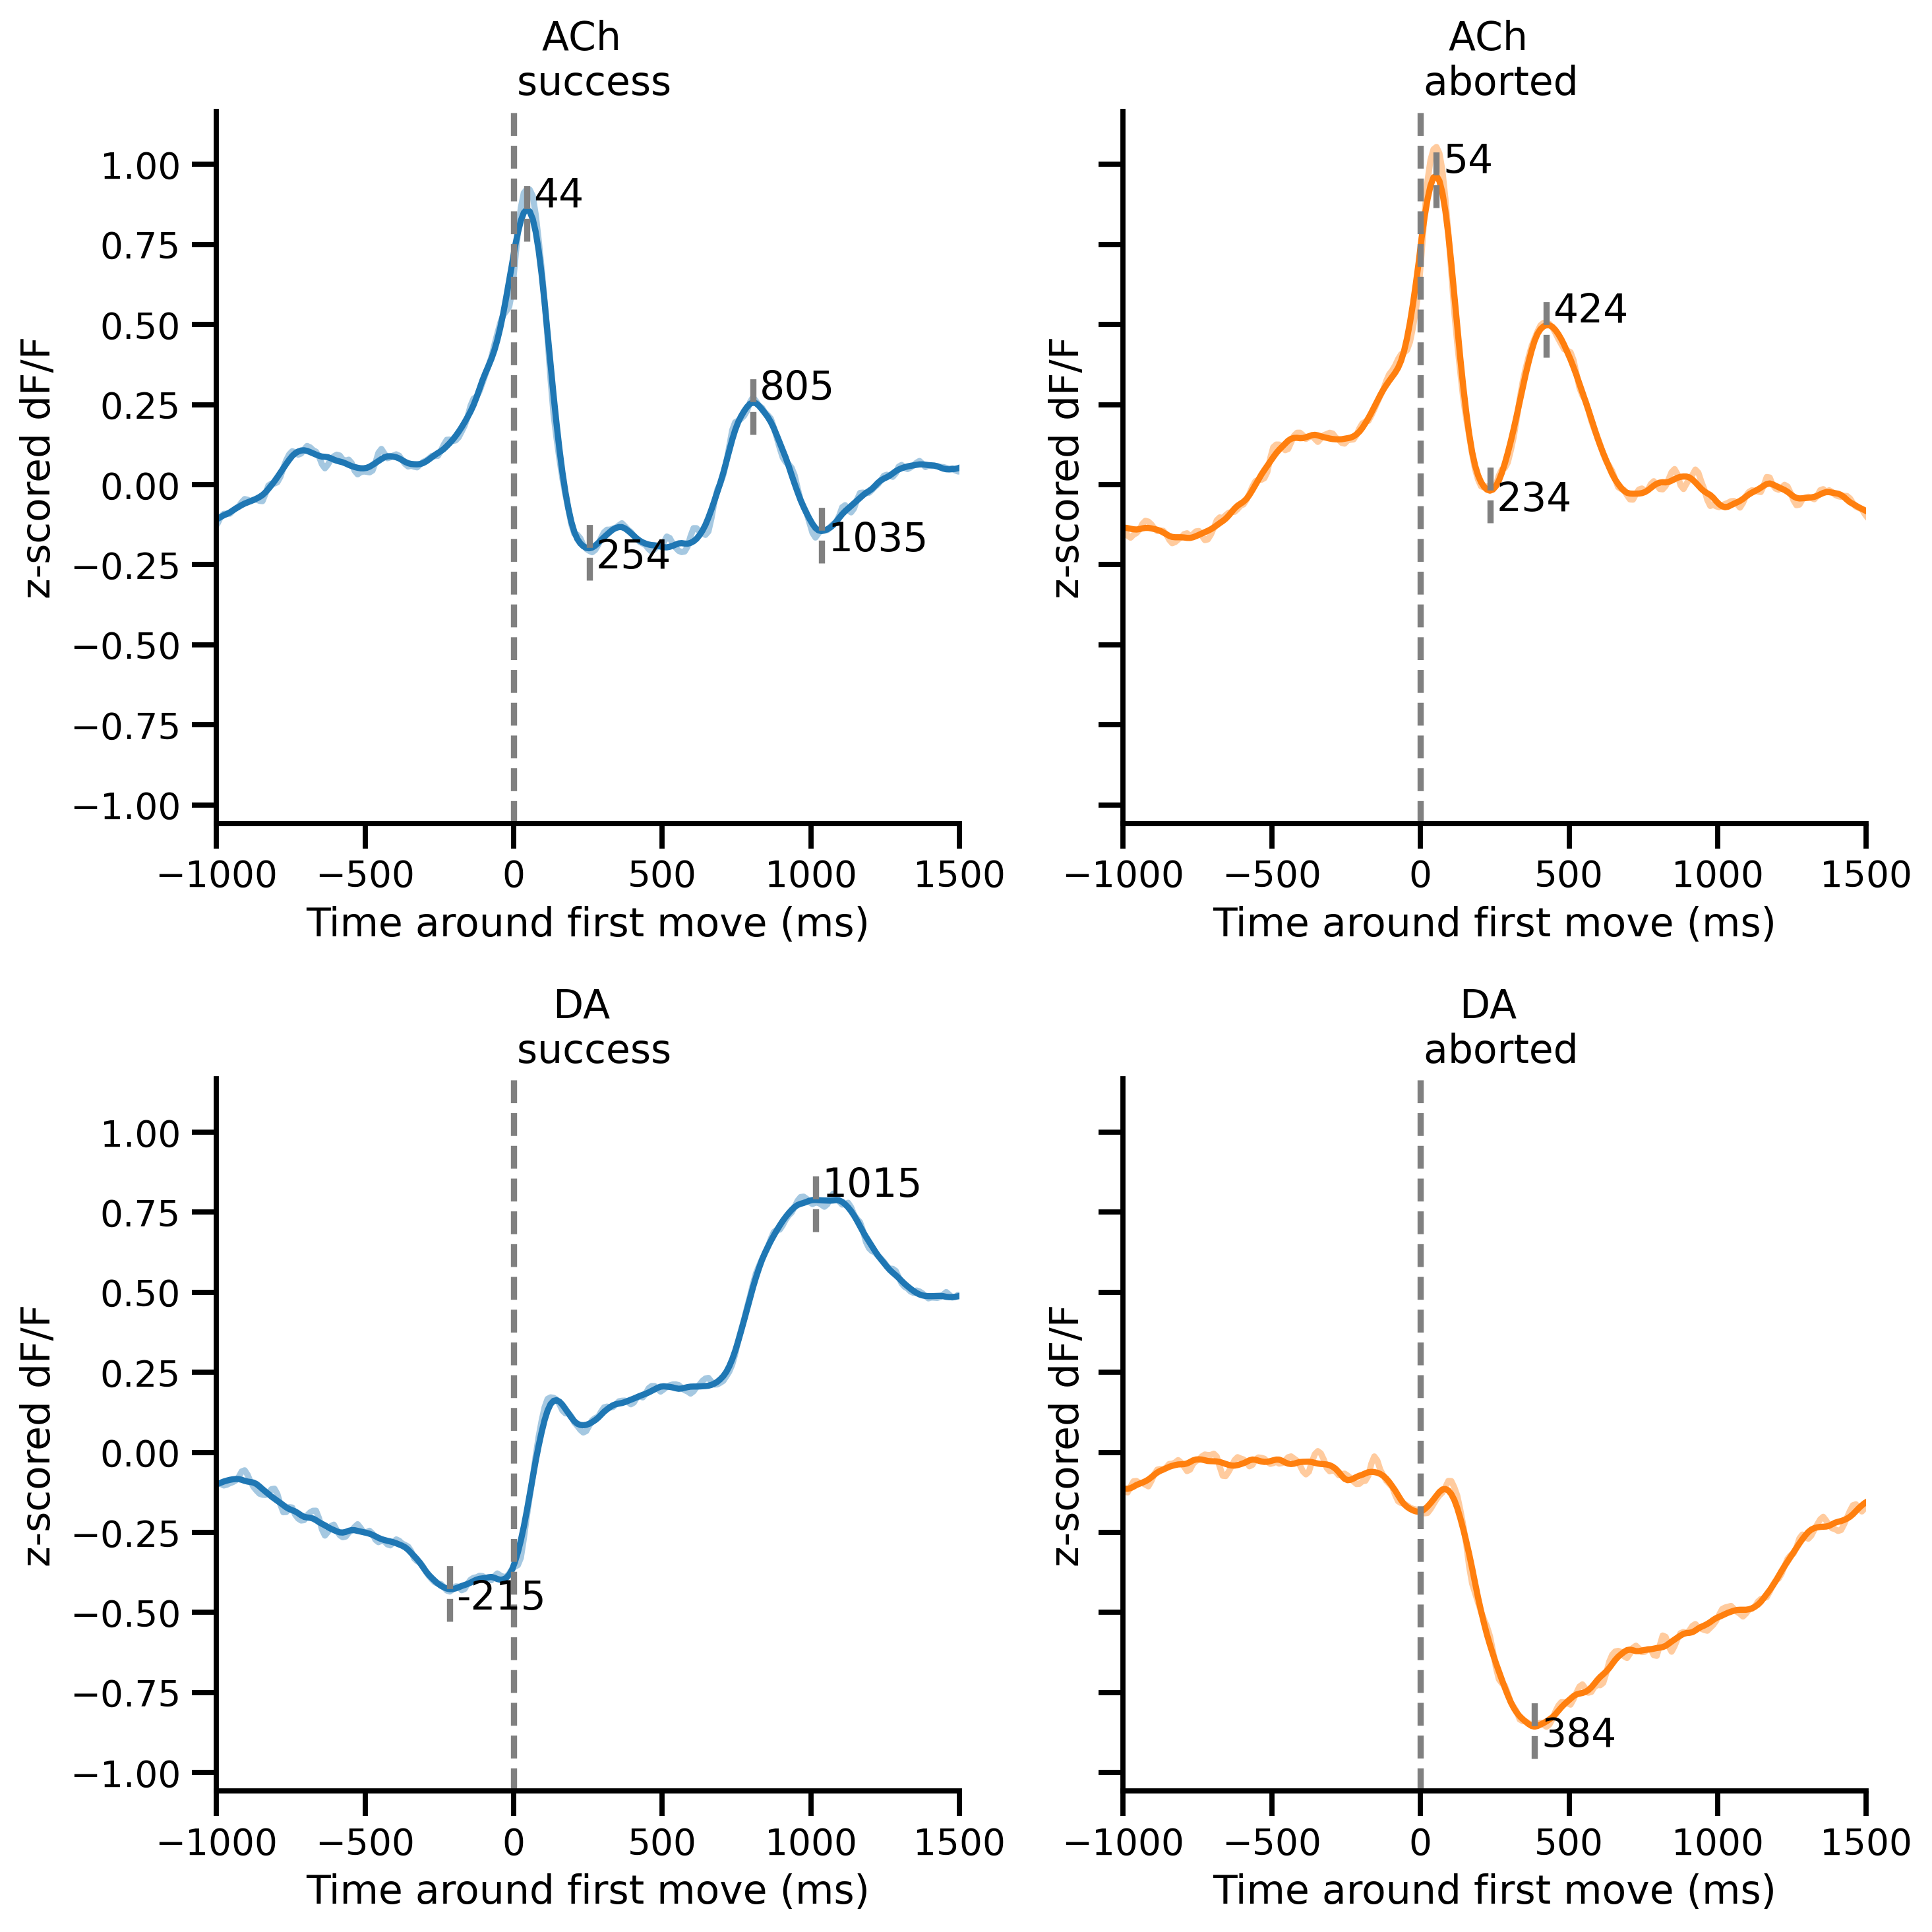

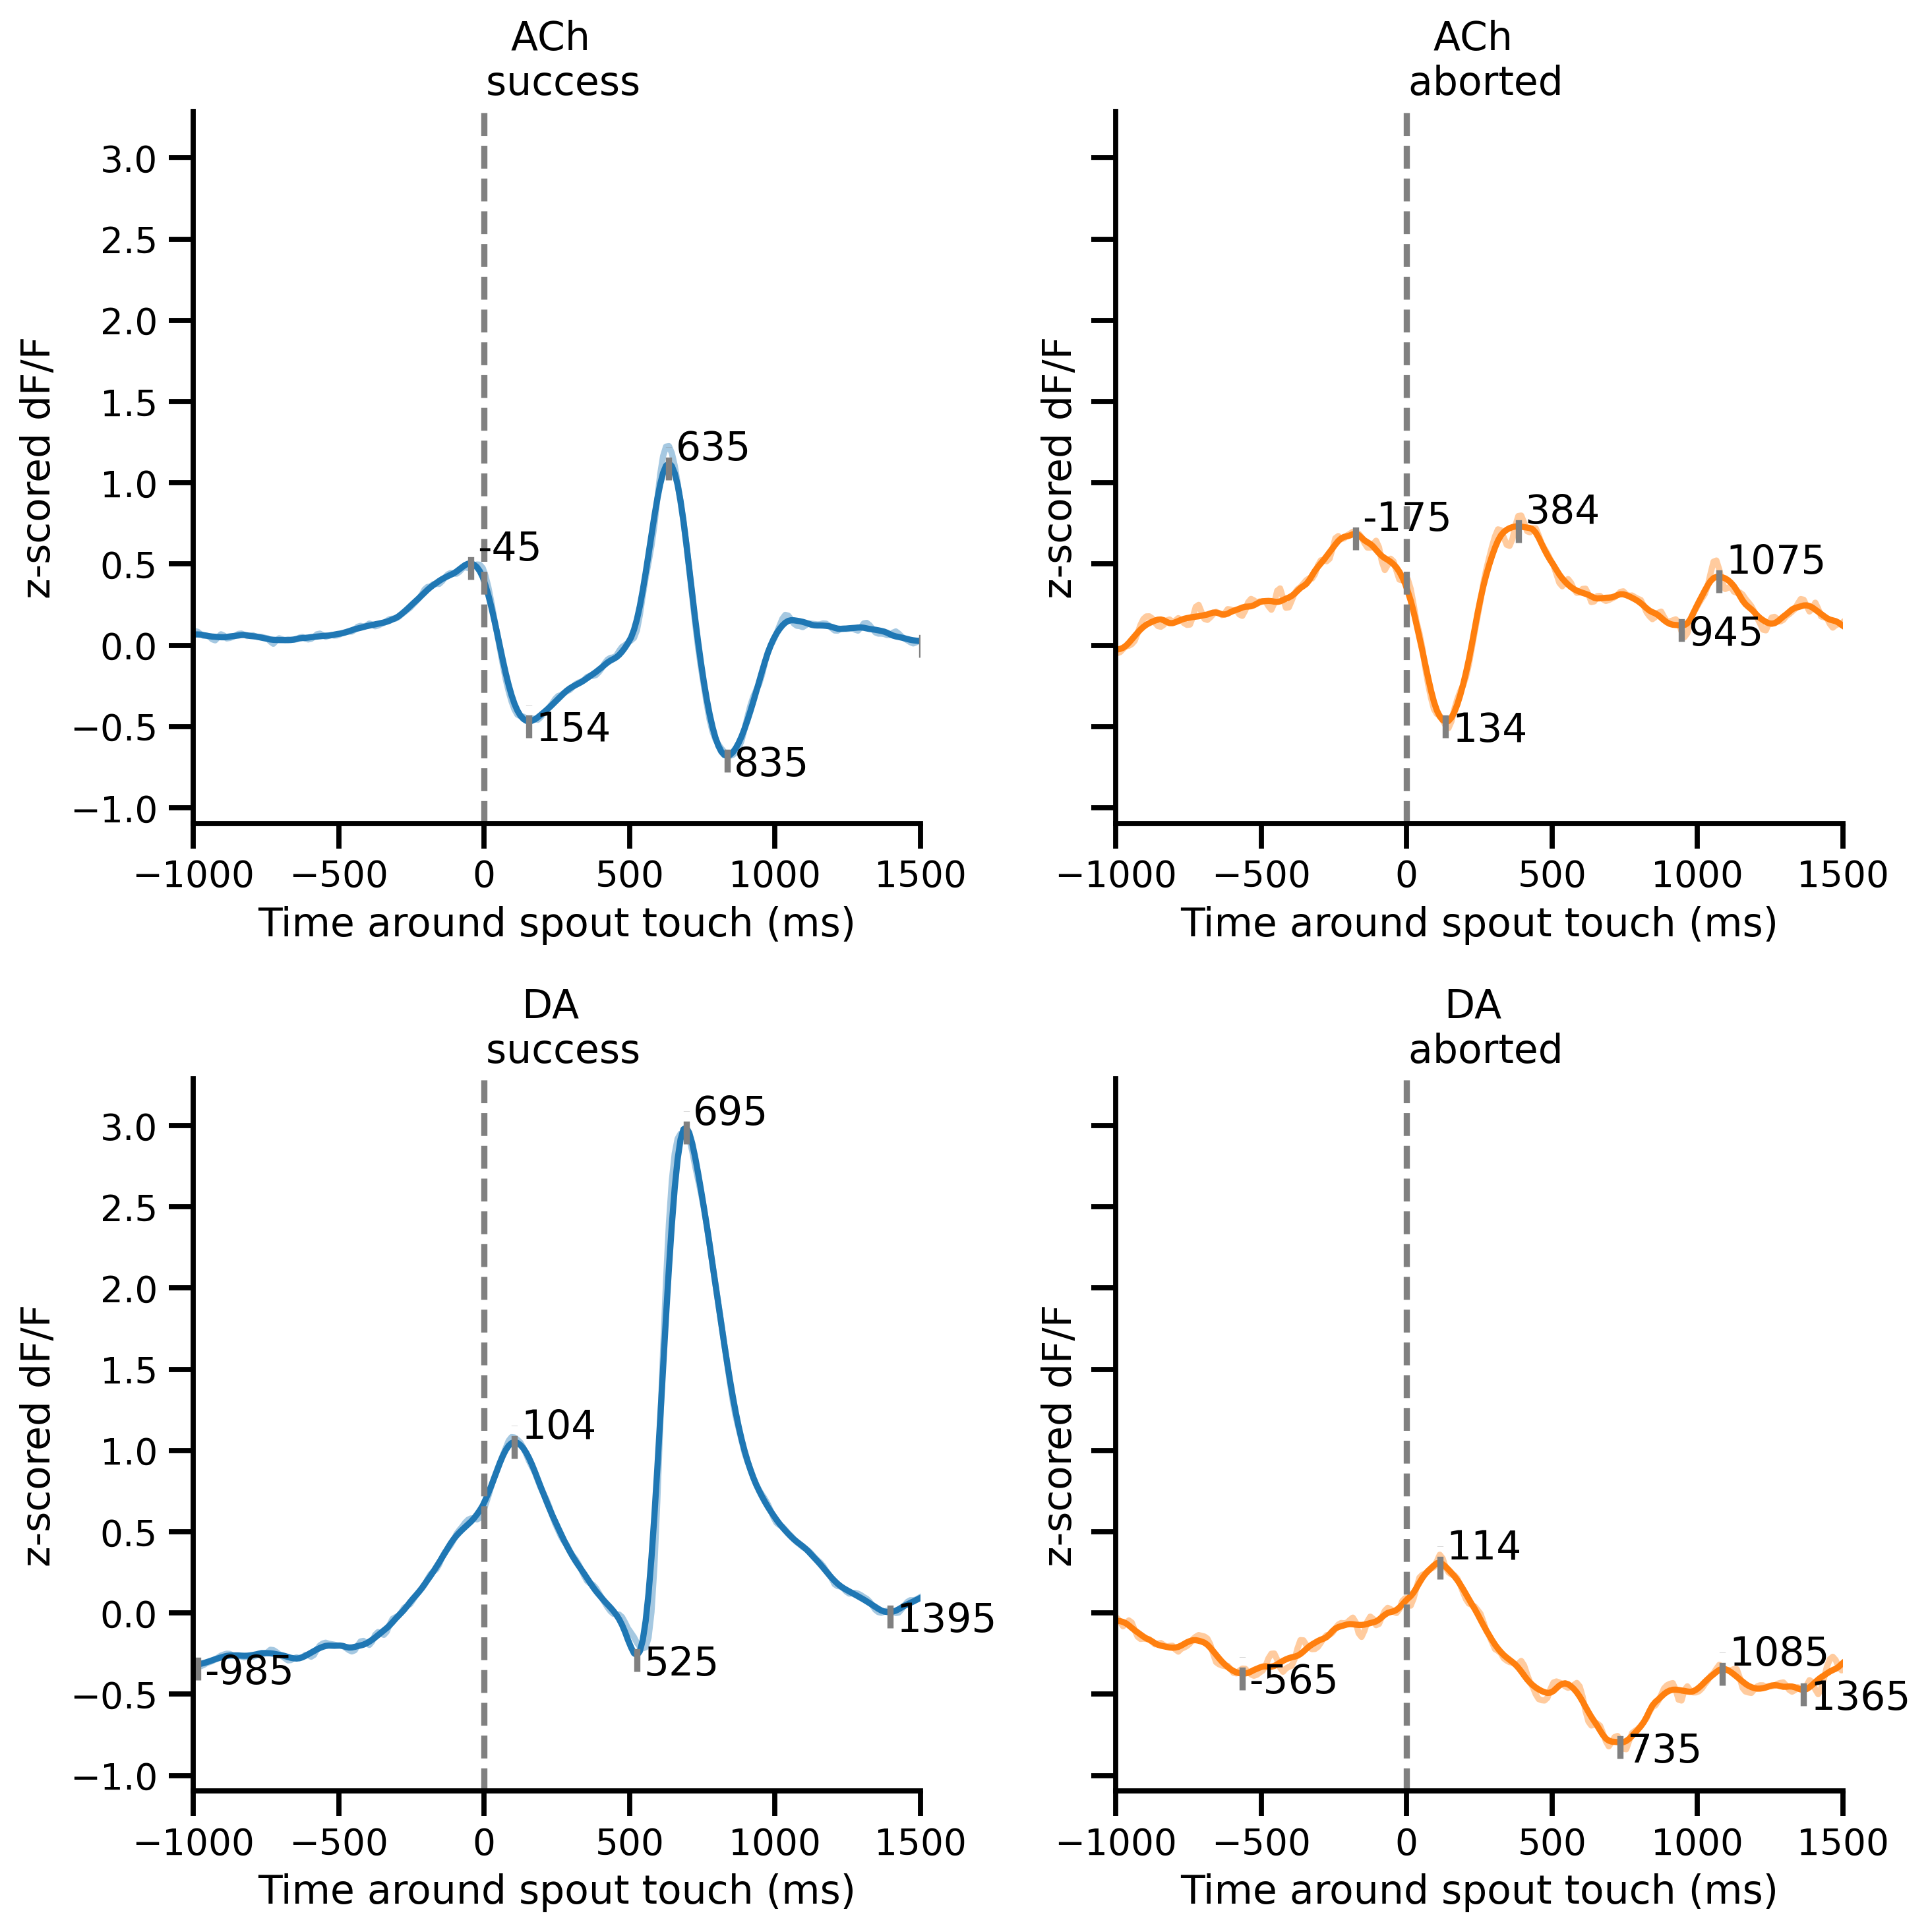

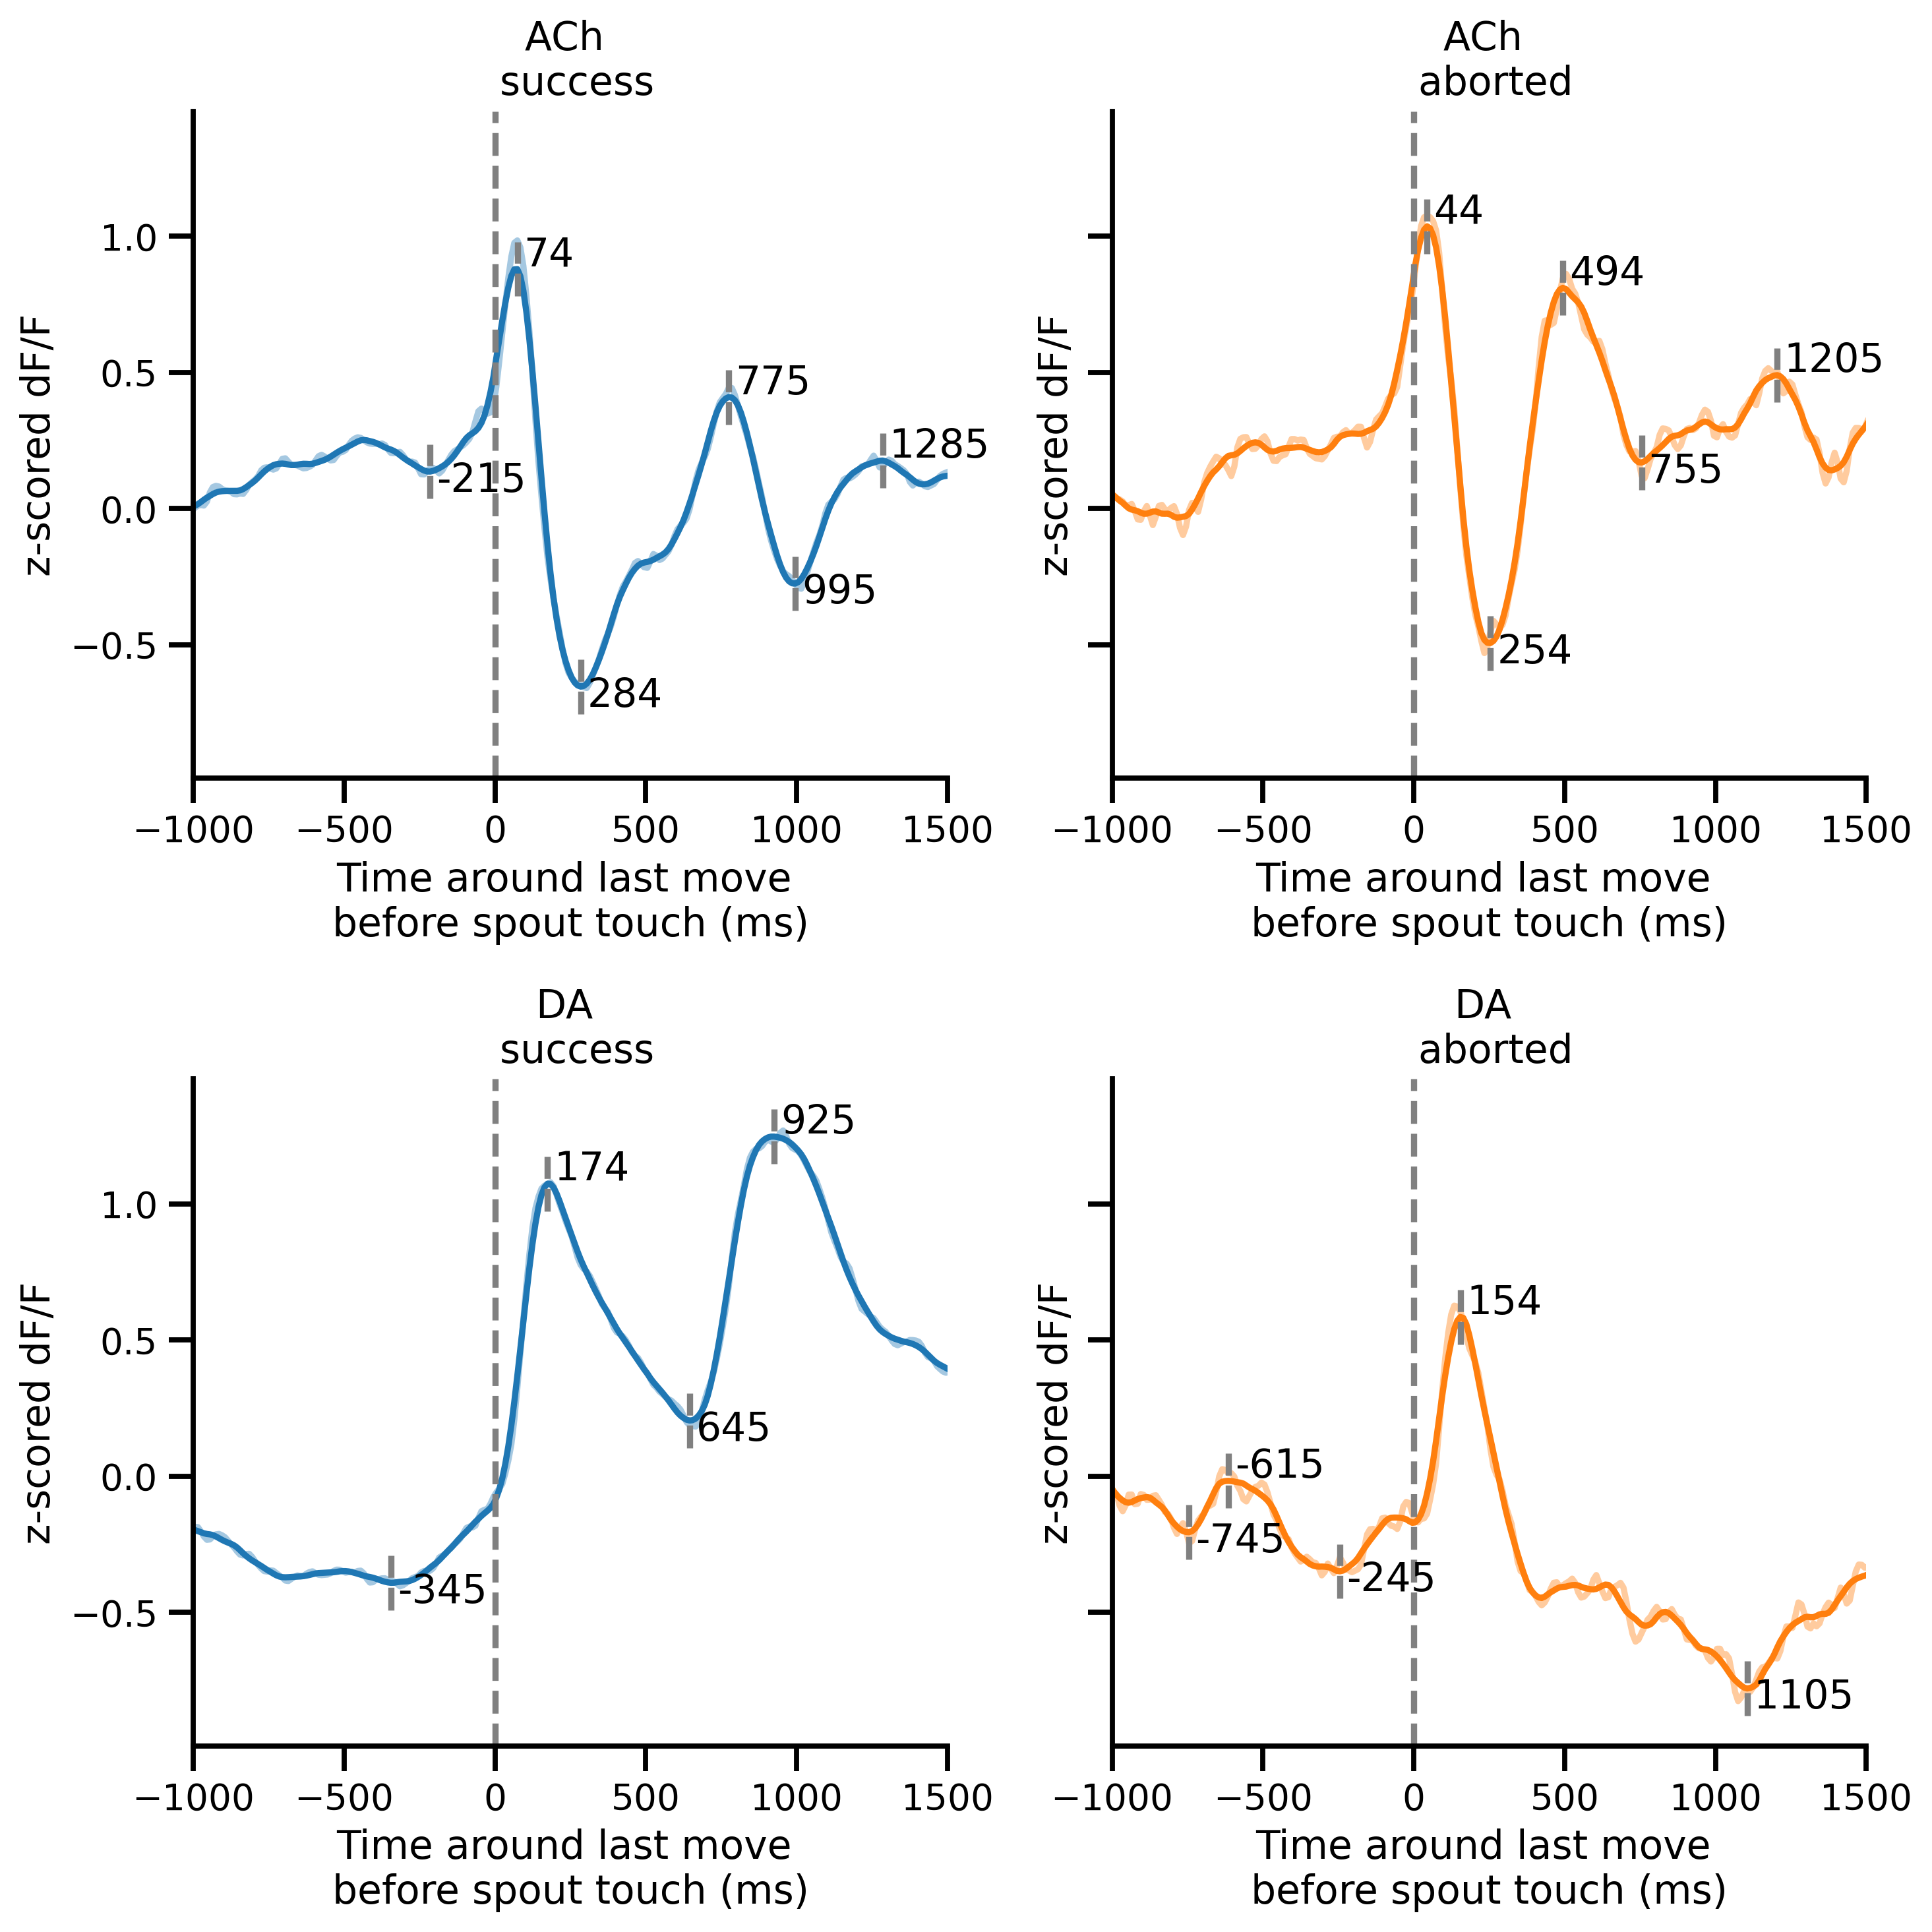

In [81]:
sns.set_context('talk',font_scale=0.8)

vars_to_plot = ['hold_for_water_zscored_df_over_f', 
                'first_bar_off_zscored_df_over_f',
                'first_spout_zscored_df_over_f',
                'last_bar_off_zscored_df_over_f']

xlabels = {'hold_for_water_zscored_df_over_f': 'Time around cue onset (ms)',
          'first_bar_off_zscored_df_over_f': 'Time around first move (ms)',
          'first_spout_zscored_df_over_f': 'Time around spout touch (ms)',
          'last_bar_off_zscored_df_over_f': 'Time around last move \nbefore spout touch (ms)'}

# vars_to_plot = ['last_bar_off_zscored_df_over_f']

for v in tqdm(vars_to_plot):
    
    xlabel = xlabels[v]
    
    fig, ax = plt.subplots(2, 2, figsize=(10,10),dpi=300,sharey=True)

    plot_peak_analysis_comparison(ds_combined_ACh, animal_id_ACh, v, 'success', 'ACh', ax.flat[0], xlabel=xlabel)
    plot_peak_analysis_comparison(ds_combined_ACh, animal_id_ACh, v, 'aborted', 'ACh', ax.flat[1], xlabel=xlabel)

    plot_peak_analysis_comparison(ds_combined_DA, animal_id_DA, v, 'success', 'DA', ax.flat[2], xlabel=xlabel)
    plot_peak_analysis_comparison(ds_combined_DA, animal_id_DA, v, 'aborted', 'DA', ax.flat[3], xlabel=xlabel)

    fig.tight_layout()
    
    fig.savefig(f'{figure_out_path}/peak_analysis/peaks_{v}.png', bbox_inches='tight')

## Scratch pad for dev

In [8]:
v = 'last_bar_off_zscored_df_over_f'
dfmean = get_average_curve(ds_combined_ACh, animal_id_ACh, v, average_method='equal_subsample')

{'prominences': array([0.23386693, 1.25793858, 0.21468729, 0.10889316, 0.13936588]),
 'left_bases': array([ 17, 204, 255, 255, 255]),
 'right_bases': array([204, 255, 323, 359, 491]),
 'widths': array([26.74605021, 21.49362294, 29.57196894, 11.78142888, 12.32375904]),
 'width_heights': array([ 0.05210042, -0.09746995, -0.32912988, -0.17267889,  0.02115122]),
 'left_ips': array([ 54.02682499, 214.30904887, 284.59133041, 335.6003929 ,
        408.87993885]),
 'right_ips': array([ 80.7728752 , 235.80267182, 314.16329935, 347.38182178,
        421.20369789])}

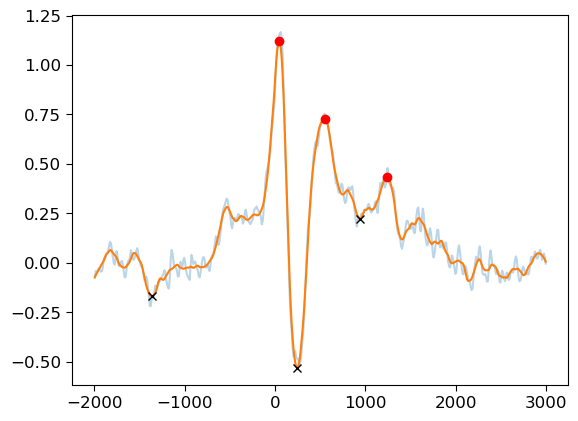

In [71]:
def filter_peaks(peaks, peak_props,max=3):
    # only select the first few prominent peak
    idx =  np.argsort(peak_props['prominences'])[::-1][:max]
    return peaks[idx]

df = dfmean[dfmean.trial_outcome=='aborted']
curve = df[v].values
event_time = df['event_time'].values

curve_smooth = signal.savgol_filter(curve,21,2)
peaks_pos, props = signal.find_peaks(curve_smooth, prominence=0.1, width=0)
peaks_pos = filter_peaks(peaks_pos, props)

peaks_neg, props = signal.find_peaks(-curve_smooth, prominence=0.1, width=0)
peaks_neg = filter_peaks(peaks_neg, props)


# peaks_pos = signal.find_peaks_cwt(curve_smooth, np.arange(1,50), noise_perc=1)

# z = np.polyfit(event_time, curve, 12)
# p = np.poly1d(z)

plt.plot(event_time, curve, alpha=0.3)
plt.plot(event_time,  curve_smooth)
plt.plot(event_time[peaks_pos],  curve_smooth[peaks_pos],'ro')
plt.plot(event_time[peaks_neg],  curve_smooth[peaks_neg],'kx')

props

[]
[]


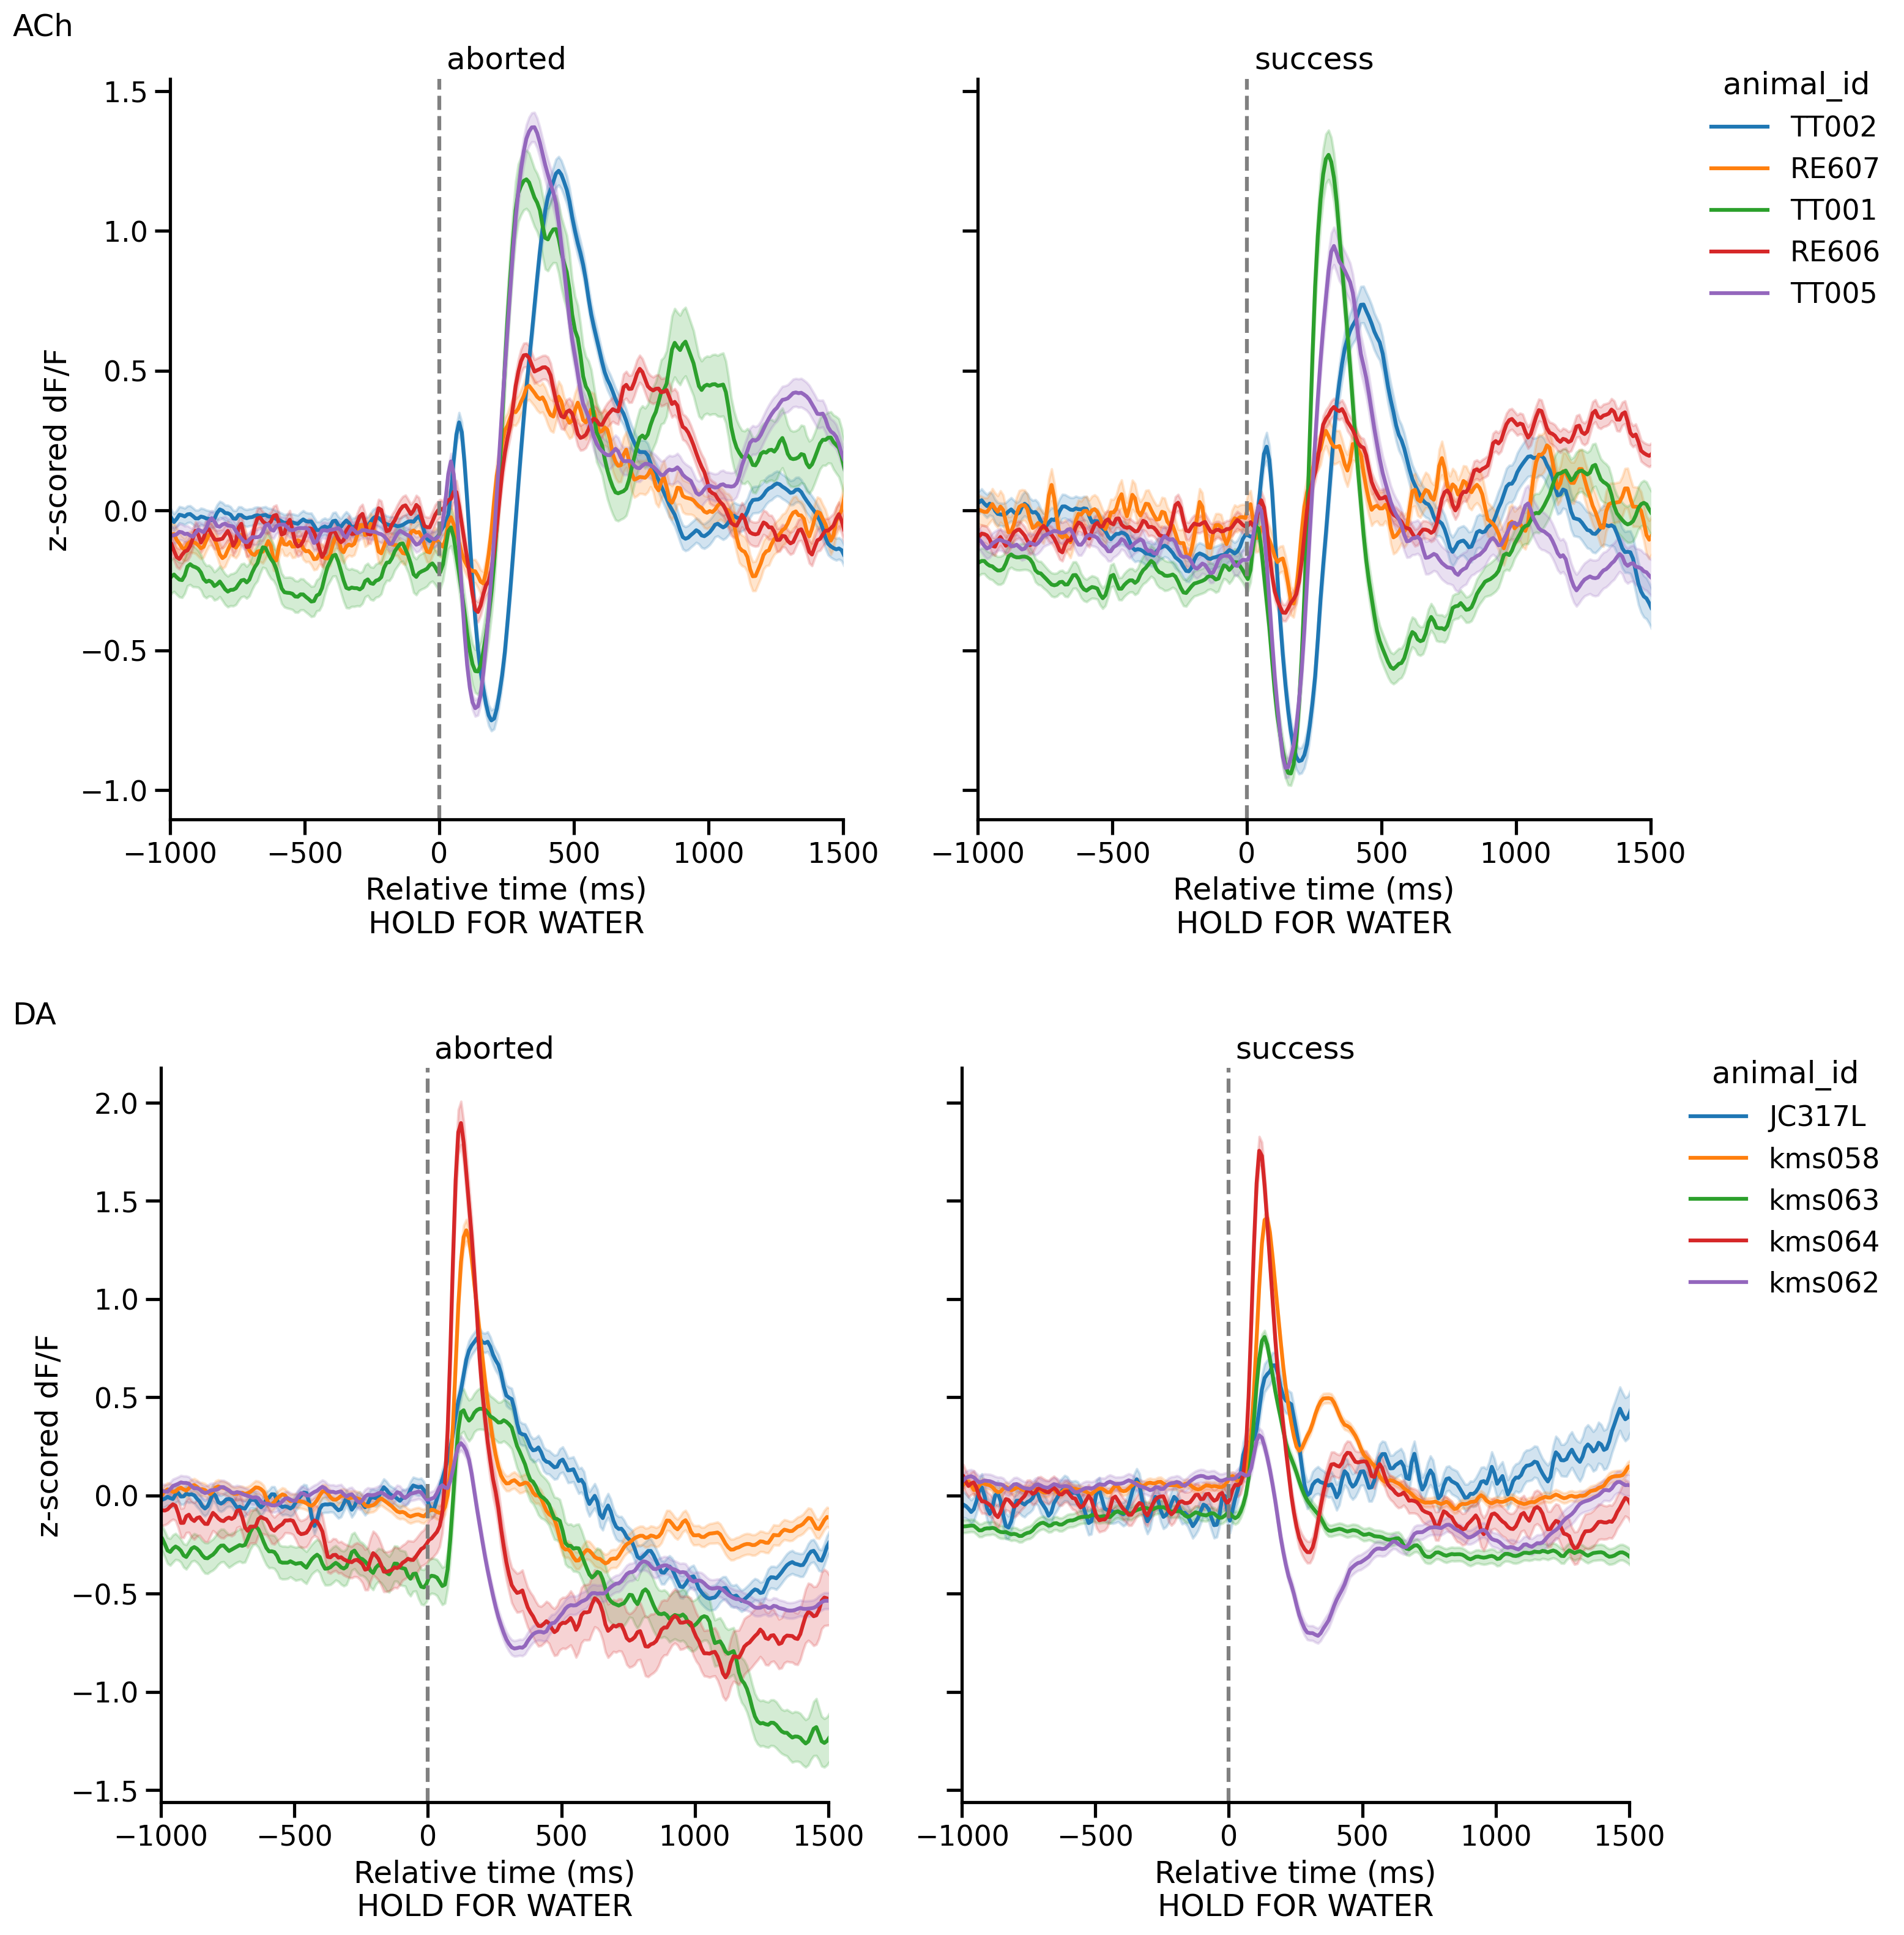

In [33]:
# vars_to_plot = ['hold_for_water_zscored_df_over_f', 
#                 'first_bar_off_zscored_df_over_f',
#                 'first_spout_zscored_df_over_f',
#                 'last_bar_off_zscored_df_over_f']

sns.set_context('talk',font_scale=1)

vars_to_plot = ['hold_for_water_zscored_df_over_f']

errorbar = 'se'

pw.clear() #patchworklib keep a set of global objects, need to clear them first
pw.overwrite_axisgrid()

for v in vars_to_plot:

    g1, fig1, df2plot = plot_subject_average(ds_combined_DA, animal_id_DA, v, errorbar=errorbar)
    g2, fig2, _ = plot_subject_average(ds_combined_ACh, animal_id_ACh, v, errorbar=errorbar)
    

    g1 = pw.load_seaborngrid(g1, label='DA',figsize=(12,6))
    g1.move_legend('upper left', bbox_to_anchor=(1,1))
    g1.case.set_title('DA', x=0, y=1)
    
    g2 = pw.load_seaborngrid(g2, label='ACh', figsize=(12, 6))
    g2.move_legend('upper left', bbox_to_anchor=(1,1))
    g2.case.set_title('ACh', x=0, y=1)

    
    g21 = g2.outline/g1.outline
    display(g21)
    # fig.savefig(f'figures/combined/subject_average_{v}_{mode}.png', bbox_inches='tight')

In [29]:
df = df2plot.groupby(['animal_id','trial_outcome','trial_nb']).first().reset_index()
df_count = df.groupby(['animal_id','trial_outcome'])['trial_nb'].count()

In [32]:
df_count['kms058']['success']

273